In [1]:
import os
import time
import copy
import numpy as n
import numpy.lib.recfunctions as rfn
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

import torch
from torch import nn

In [2]:
import pickle

## Functions
#### Load data files
`data_root` should contain the root directory of the folder downloaded from Dropbox.

In [3]:
def load_data(data_root, dlc_dir, ann_dir, verbose=False):
    
    dlc_path = os.path.join(data_root, dlc_dir)
    ann_path = os.path.join(data_root, ann_dir)
    all_data = {}
    if verbose: print("Loading files: ")
    for f_name in os.listdir(dlc_path):
        if f_name[-3:] != 'npy':
            continue

        dlc_file=os.path.join(dlc_path, f_name)
        ann_file=os.path.join(ann_path, 'Annotated_' + f_name)
        if verbose: print("\t" + f_name + "\n\tAnnotated_" + f_name)
        data_dlc = n.load(dlc_file)
        data_ann = n.load(ann_file)
        labels = data_dlc[0]
        dtype = [('t', n.int), ('ann', 'U30')]
        i = 0
        for label in data_dlc[0]:
            i += 1
            coord = 'x' if i % 2 == 0 else 'y'
            dtype += [(label + '_' + coord , n.float32 )]

        data_concat = n.concatenate((data_ann, data_dlc[1:]),axis=1)
        data = n.array(n.zeros(data_concat.shape[0]), dtype = dtype)
        for i in range(data_concat.shape[1]):
            data[dtype[i][0]] = data_concat[:, i]
        all_data[f_name[:-4]] = data
    return all_data

#### Velocities

In [4]:
def dot(a, b):
    return n.sum(a * b, axis=-1)

def mag(a):
    return n.sqrt(n.sum(a*a, axis=-1))

def get_angle(a, b):
    cosab = dot(a, b) / (mag(a) * mag(b)) # cosine of angle between vectors
    angle = n.arccos(cosab) # what you currently have (absolute angle)

    b_t = b[:,[1,0]] * [1, -1] # perpendicular of b

    is_cc = dot(a, b_t) < 0

    # invert the angles for counter-clockwise rotations
    angle[is_cc] = 2*n.pi - angle[is_cc]
    return 360 - n.rad2deg(angle)

In [5]:
def calculate_velocity(trial):
    names = []; dtypes = []; datas = []
    velocities_calculated = []
    for label in trial.dtype.names:
        if label[-2:] in ['_x', '_y']:
            names.append(label+'_vel')  
            dtypes += [n.float]
            datas += [n.zeros(trial.shape[0])]
            velocities_calculated.append(label)
    trial = rfn.append_fields(trial, names, datas, dtypes)
    trial = n.array(trial, trial.dtype)
    for label in velocities_calculated:
        vel = n.gradient(trial[label])
        trial[label + '_vel'] = vel
    return trial
def normalize_trial(trial, feature_labels, nan = -10000):
    ref_x = trial[feature_labels[1]].copy()
    ref_y = trial[feature_labels[0]].copy()
    for i,label in enumerate(feature_labels):
        if label[-1] == 'y':
    #         print('y-pre:',n.nanmax(features[:,i]))
            trial[label] -= ref_y
    #         print('y-post:', n.nanmax(features[:,i]))
        elif label[-1] == 'x':
    #         print('x-pre:',n.nanmax(features[:,i]))
            trial[label] -= ref_x
    #         print('x-post:', n.nanmax(features[:,i]))

    mouse_1_pos_labels = []
    mouse_2_pos_labels = []
    mouse_1_vel_labels = []
    mouse_2_vel_labels = []
    for label in feature_labels:
        if label[-3:] == 'vel':
            if label[-7] == '1':
                mouse_1_vel_labels.append(label)
            else:
                mouse_2_vel_labels.append(label)
        else:
            if label[-3] == '1':
                mouse_1_pos_labels.append(label)
            else:
                mouse_2_pos_labels.append(label)


    mouse_1_pos = n.zeros((len(mouse_1_pos_labels),len(trial)))
    for i,l in enumerate(mouse_1_pos_labels): mouse_1_pos[i]=trial[l]
    mouse_2_pos = n.zeros((len(mouse_2_pos_labels),len(trial)))
    for i,l in enumerate(mouse_2_pos_labels): mouse_2_pos[i]=trial[l]
    mouse_1_vel = n.zeros((len(mouse_1_vel_labels),len(trial)))
    for i,l in enumerate(mouse_1_vel_labels): mouse_1_vel[i]=trial[l]
    mouse_2_vel = n.zeros((len(mouse_2_vel_labels),len(trial)))
    for i,l in enumerate(mouse_2_vel_labels): mouse_2_vel[i]=trial[l]
    # TODO how to normalize??
    trial_data = n.concatenate([mouse_1_pos, mouse_2_pos, mouse_1_vel, mouse_2_vel])
    if nan is not None:
        trial_data = n.nan_to_num(trial_data, nan=nan)
    
    trial_labels = n.concatenate([mouse_1_pos_labels, mouse_2_pos_labels, mouse_1_vel_labels, mouse_2_vel_labels])
    
    return trial_data, trial_labels

## Separate train, test and val sets

In [6]:
def split_sets(features_all,targets_all, chunk_size=500, split = 0.8, separate_vid_idx = None):
    data_len = features_all.shape[0]
    num_chunks = int(data_len // chunk_size)
    chunk_list = n.random.choice(range(num_chunks), size=num_chunks, replace=False)

    test_chunk_idx_bound = split*num_chunks

    features_train = []
    features_test = []
    targets_train = []
    targets_test = []
    
    if separate_vid_idx is not None:
        targets_separate = []
        features_separate = []

    for i in range(num_chunks):
        curr_chunk_idx = chunk_list[i]*chunk_size
        curr_chunk = features_all[curr_chunk_idx:curr_chunk_idx+chunk_size,:]
        curr_chunk_t = targets_all[curr_chunk_idx:curr_chunk_idx+chunk_size]
#         print(curr_chunk_idx)
        if separate_vid_idx is not None and curr_chunk_idx+chunk_size > separate_vid_idx[0] and curr_chunk_idx < separate_vid_idx[1]:
#                 print(curr_chunk_idx, separate_vid_idx[0])
#                 print(curr_chunk_idx+chunk_size, separate_vid_idx[1])
                targets_separate.append(curr_chunk_t)
                features_separate.append(curr_chunk)
        elif i < test_chunk_idx_bound:
#             print("train!!")
            features_train.append(curr_chunk)
            targets_train.append(curr_chunk_t)
        else:
#             print('test')
            features_test.append(curr_chunk)
            targets_test.append(curr_chunk_t)
        
    features_train = n.concatenate(features_train, axis=0)
    features_test = n.concatenate(features_test, axis=0)
    
    targets_test = n.concatenate(targets_test)
    targets_train = n.concatenate(targets_train)
    
    if separate_vid_idx is None:
        return features_train, features_test, targets_train, targets_test
    else:
        features_separate = n.concatenate(features_separate, axis=0)
        targets_separate = n.concatenate(targets_separate)
        return features_train, features_test, features_separate,\
                targets_train, targets_test, targets_separate

def str_to_int(targets, mapping = None):
    categories = n.unique(targets)
    N_categories = len(categories)
    if mapping is None:
        mapping = {}
        i = 0
        for c in categories:
            mapping[c] = i
            i += 1
    targets_int = n.array([mapping[s] for s in targets], dtype=int)
    
    return targets_int, mapping
    

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class MLP():
    def __init__(self, architecture):
        self.architecture = architecture
        
        self.D_in = self.architecture['D_in']
        self.D_out = self.architecture['D_out']
        self.hidden_dims = self.architecture['hidden_dims']
        
        self.layers = []
        prev_dim = self.architecture['D_in']
        for dim in self.architecture['hidden_dims']:
            self.layers += [torch.nn.Linear(prev_dim, dim),
                           torch.nn.ReLU()]
            prev_dim = dim
        self.layers += [torch.nn.Linear(prev_dim, self.D_out)]
        self.model = nn.Sequential(*self.layers)
        
        self.trackers = {}

    def init_weights(self):
        self.model.apply(init_weights)
   
    def start_trackers(self,track, reset_trackers=True):
        if reset_trackers: self.trackers = {}
        for t in track:
            self.trackers[t] = []
    
    def track(self):
        for variable in self.trackers.keys():
            self.trackers[variable].append(copy.deepcopy(getattr(self, variable)))
        
    def learn(self,learning, training_set, test_set, reset_trackers=True, verbose=True):
        
        #self.init_weights()
        
        # set up variables
        N_batch = learning['N_batch']
        N_epochs = learning['N_epochs']
        loss_fn = learning['loss_fn']
        print_interval = learning['print_interval']
        track = learning['track']
        learning_rate = learning['learning_rate']
        
        self.learning = learning
        
        optimizer = learning['optimizer'](self.model.parameters(), learning_rate)
        self.start_trackers(track, reset_trackers)
        
        # load data
        x_train, y_train = training_set
        x_test, y_test = test_set

        N_training = len(y_train)
        N_test = len(y_test)
    
        self.t = 0
        tic = time.time()
        end = False
        for self.epoch_idx in range(N_epochs):
            if verbose: print("### EPOCH {:2d} ###".format(self.epoch_idx))
                
            # randomize batches
            indices = n.random.choice(range(N_training), N_training, False)
            num_batches = len(indices) // N_batch + 1

            for self.batch_idx in range(num_batches):
                # load batch
                b_idx = self.batch_idx
                x_train_batch = x_train[indices[b_idx*N_batch :(b_idx+1)*N_batch]]
                y_train_batch = y_train[indices[b_idx*N_batch : (b_idx+1)*N_batch]]

                
                # predict, loss and learn
                y_train_batch_pred = self.model(x_train_batch)
                loss = loss_fn(y_train_batch_pred, y_train_batch)
                self.train_loss = loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                self.t += 1

                if self.batch_idx % print_interval == 0:
                    
#                     y_train_pred = self.model(x_train)
#                     self.train_loss = loss_fn(y_train_pred, y_train).item()
#                     pred_labels = n.argmax(y_train_pred.detach().numpy(),axis=1)
#                     true_labels = y_train.detach().numpy()
#                     correct_preds = n.array(pred_labels == true_labels, n.int)
                    self.train_frac_correct = 0# n.mean(correct_preds)
                    
                    y_test_pred = self.model(x_test)
                    self.test_loss = loss_fn(y_test_pred, y_test).item()
                    pred_labels = n.argmax(y_test_pred.detach().numpy(),axis=1)
                    true_labels = y_test.detach().numpy()
                    correct_preds = n.array(pred_labels == true_labels, n.int)
                    self.test_frac_correct = n.mean(correct_preds)

                    toc = time.time()
                    delta = toc - tic
                    tic = toc
                    print("Time: {:4.2f}, Batch {:3d}, Train Loss (for batch): {:4.2f}, Test Loss: {:4.2f}, Test Correct Frac: {:.3f}".format(\
                                       delta, self.batch_idx, self.train_loss, self.test_loss, self.test_frac_correct))
            
                    self.track()

In [8]:
def plot_net_results(net, x_test, y_test):
    plt.plot(net.trackers['t'],net.trackers['train_loss'], label='train')
    plt.plot(net.trackers['t'],net.trackers['test_loss'], label='test')
    plt.title("Cross Entropy Loss through training")
    plt.legend()
    plt.ylim(0,10)
    plt.show()
    
    plt.plot(net.trackers['t'], net.trackers['test_frac_correct'])
    plt.title("Fraction of correct labels on test set through training")
    plt.ylim(0.5,1)
    plt.show()
    
    max_perf_ind = n.argmax(net.trackers['test_frac_correct'])
    min_loss_ind = n.argmin(net.trackers['test_loss'])
    max_perf_model = net.trackers['model'][max_perf_ind]
    
    prediction_test = max_perf_model(x_test)
    pred = n.argmax(prediction_test.detach().numpy(),axis=1)
    true = y_test.detach().numpy()
    confmat = confusion_matrix(true, pred, normalize='true')
    f, ax = plt.subplots(figsize=(10,10))
    m = ax.matshow(confmat, cmap='Blues', vmin=0,  vmax=1)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_xticks(list(range(len(categories))))
    ax.set_xticklabels(categories, rotation=45)
    ax.set_yticks(list(range(len(categories))))
    ax.set_yticklabels(categories, rotation=45)
    f.colorbar(m)
    
    plt.show()

In [9]:

class LSTM_net(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim, n_layers_LSTM, dropout_prob):
        super(LSTM_net, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_layers = n_layers_LSTM
        
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, 
                            num_layers  = n_layers_LSTM, dropout = dropout_prob,batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
#         self.out_func = nn.Softmax(dim=1)
    def forward(self, x, hidden=None):
        batch_size = x.size(0)
#         x = x.long()
#         print(x.shape)
        if hidden is None:
            lstm_out, hidden = self.lstm(x)
        else: 
            lstm_out, hidden = self.lstm(x,hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = out.view(batch_size, self.output_dim, -1)[:,:,-1]
        
        return out, hidden
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [10]:
def extract_data(datas, n_window, n_stride, test_vids=[3,4],batch_size=32, shuffle=True):
    datapoints = []
    labels = []

    trial_bounds = []

    trial_idx = 0
    idx = 0
    
    for data in datas:  
        trial_bounds.append(idx)
        for i in range(int(data.shape[1]/n_stride)):
            if (i*n_stride + n_window) < data.shape[1]:
                datapoints.append(data[:,i*n_stride : i*n_stride + n_window])
                new_labels = [all_data[trial_keys[trial_idx]]['ann'][i*n_stride + int(n_window/2)]]
                new_labels = [target_map[l] for l in new_labels]
                labels.append(new_labels)
                idx += 1
        trial_idx += 1
    trial_bounds.append(idx)  
    
    Xs = n.stack(datapoints)
    Ys = n.stack(labels)
    num_features = Xs.shape[1]
    
    Xs_train = []; Ys_train = []; Xs_test = []; Ys_test = []
    for i in range(len(trial_bounds)-1):
        if i in test_vids:
            Xs_test.append(Xs[trial_bounds[i]:trial_bounds[i+1]-1])
            Ys_test.append(Ys[trial_bounds[i]:trial_bounds[i+1]-1])
        else:
            Xs_train.append(Xs[trial_bounds[i]:trial_bounds[i+1]-1])
            Ys_train.append(Ys[trial_bounds[i]:trial_bounds[i+1]-1])
#     print(Xs_train[0].shape)
    Xs_train = n.concatenate(Xs_train,axis=0).reshape(-1, n_window, num_features)
    Ys_train = n.concatenate(Ys_train,axis=0).reshape(-1)
    Xs_test = n.concatenate(Xs_test,axis=0).reshape(-1, n_window, num_features)
    Ys_test = n.concatenate(Ys_test,axis=0).reshape(-1)
    
    
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(Xs_train), torch.from_numpy(Ys_train))
    test_data = torch.utils.data.TensorDataset(torch.from_numpy(Xs_test), torch.from_numpy(Ys_test))

    train_loader = torch.utils.data.DataLoader(train_data, shuffle=shuffle, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, shuffle=shuffle, batch_size=batch_size)
    
    return train_data, train_loader, test_data, test_loader

In [11]:
def test_model(params, datas, device, random_val):
    train_data, train_loader, val_data, val_loader \
            = extract_data(datas, params['n_windows'], params['n_stride'],
                        batch_size=params['batch_size'],shuffle=params['shuffle'])
        
    model = LSTM_net(params['input_dim'], params['hidden_dim'], params['output_dim'], params['n_layers_LSTM'], params['dropout_prob'])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    model.to(device)
    model.train()

    params['val_losses'] = []
    params['val_fracs'] = []
    
    counter = 0 
    tic = time.time()
    for i in range(params['N_epochs']):
        h = model.init_hidden(params['batch_size'])
        for inputs, labels in train_loader:
            if inputs.shape[0] != params['batch_size']: continue
            counter += 1
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            model.zero_grad()
            output, h = model(inputs.float(), (h[0].float(), h[1].float()))
            loss = criterion(output.squeeze(), labels[:].long())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), params['clip'])
            optimizer.step()
                        
        toc = time.time() - tic
        tic = time.time()
        
        if counter%params['print_every'] == 0:
            val_h = model.init_hidden(params['batch_size'])
            val_losses = []
            model.eval()
            fracs = []
            for inp, lab in val_loader:
                if inp.shape[0] != params['batch_size']: continue
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp.float(), [val_h[0].float(), val_h[1].float()])
                val_loss = criterion(out.squeeze(), lab[:].long())
                val_losses.append(val_loss.item())
                
                pred_labels = n.argmax(out.cpu().detach().numpy(),axis=1)
                true_labels = lab.cpu().detach().numpy()
                correct_preds = n.array(pred_labels == true_labels, n.int)
                fracs.append(n.mean(correct_preds))
                
            frac_correct_val = (n.mean(fracs))
            params['val_losses'].append(n.mean(val_losses))
            params['val_fracs'].append(frac_correct_val)
            model.train()
            print("\tEpoch: {}/{}; {:.2f} sec...".format(i+1, params['N_epochs'],toc),
                  "\tLoss: {:.3f}...".format(loss.item()),
                  "\tVal Loss: {:.3f}".format(n.mean(val_losses)),
                  "\tVal Frac: {:.4f}".format(frac_correct_val))
            if n.mean(val_losses) <= params['valid_loss_min']:
                torch.save(model.state_dict(), './state_dict' + str(random_val) + '.pt')
                print('\tValidation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(params['valid_loss_min'],n.mean(val_losses)))
                params['valid_loss_min'] = n.mean(val_losses)
            if frac_correct_val >= params['valid_frac_max']:
                params['valid_frac_max'] = frac_correct_val
                params['pred_labels_best'] = pred_labels.copy()
                params['true_labels_best'] = true_labels.copy()

                
    return params, model
                
        

## Run


In [12]:
# Load data into a structured array
data_root = 'C:/Users/Neuropixel/AH-EN'
dlc_dir = 'postprocessedXYCoordinates'
ann_dir = 'manualannotations'
all_data = load_data(data_root, dlc_dir, ann_dir)

# Choose which position labels we care about
feature_labels = all_data['Female1'].dtype.names[2:]

# Calculate velocity and preprocess/scale/normalize data
trial_keys = list(all_data.keys())
datas = []
for key in trial_keys:
    datas.append(normalize_trial(all_data[key], feature_labels)[0])
features_all = n.concatenate(datas, axis=1).T

# Format category labels
targets_all = n.concatenate([all_data[key]['ann'] for key in trial_keys]).T
targets_int, target_map = str_to_int(targets_all)
categories = target_map.keys()
N_categories = len(categories)
input_dim = datas[0].shape[0]

ERROR! Session/line number was not unique in database. History logging moved to new session 21


In [13]:
device = torch.device("cuda")

In [14]:
params_original = {
    'n_windows'      : 10,
    'n_stride'       : 5,
    'shuffle'        : True,
    'dropout_prob'   : 0.3,
    'batch_size'     : 32,
    'hidden_dim'     : 50,
    'n_layers_LSTM'  : 3, 
    'output_dim'     : N_categories,
    'input_dim'      : input_dim,
    'lr'             : 0.005,
    'N_epochs'       : 100,
    'print_every'    : 4,
    'clip'           : 5,
    'valid_loss_min' : n.Inf,
    'valid_frac_max' : 0,
}


In [15]:
sweeps = {
    'n_windows'       : [1,  5, 10],
    'lr'              : [0.0001, 0.0005, 0.001, 0.003],
}

In [17]:
n.random.seed(23581321)
torch.manual_seed(23581321)

results = []
for n_windows in sweeps['n_windows']:
    for lr in sweeps['lr']:
        params = copy.copy(params_original)
        params['n_windows'] = n_windows
        params['lr'] = lr
        
        print("\n###########\nTesting with n_windows: ", n_windows, " and lr:", lr)
        random_idx = int(n.random.random()*1e9)
        params_result, model = test_model(params, datas, device, random_idx)
        
        
        result_string = "Completed n_windows: " + str(n_windows) + " and lr:" +  str(lr) + "\n\tloss: {:.6f} \n\tfrac:{:.6f}".format(params_result['valid_loss_min'], params_result['valid_frac_max'])
        
        results.append((copy.deepcopy(params_result), copy.deepcopy(model), result_string))
        print(result_string)
        
        filename = b"run_" + bytes(str(random_idx),'ascii') + b".res"
        print(filename)
        filehandler = open(filename,"wb")
        pickle.dump(results[-1],filehandler)
        


###########
Testing with n_windows:  1  and lr: 0.0001
	Epoch: 2/100; 6.75 sec... 	Loss: 0.414... 	Val Loss: 0.450 	Val Frac: 0.8679
	Validation loss decreased (inf --> 0.450).  Saving model ...
	Epoch: 4/100; 6.48 sec... 	Loss: 0.647... 	Val Loss: 0.401 	Val Frac: 0.8843
	Validation loss decreased (0.450 --> 0.401).  Saving model ...
	Epoch: 6/100; 6.95 sec... 	Loss: 0.372... 	Val Loss: 0.348 	Val Frac: 0.9006
	Validation loss decreased (0.401 --> 0.348).  Saving model ...
	Epoch: 8/100; 7.95 sec... 	Loss: 0.391... 	Val Loss: 0.331 	Val Frac: 0.9016
	Validation loss decreased (0.348 --> 0.331).  Saving model ...
	Epoch: 10/100; 6.99 sec... 	Loss: 0.377... 	Val Loss: 0.323 	Val Frac: 0.9002
	Validation loss decreased (0.331 --> 0.323).  Saving model ...
	Epoch: 12/100; 6.53 sec... 	Loss: 0.047... 	Val Loss: 0.305 	Val Frac: 0.9066
	Validation loss decreased (0.323 --> 0.305).  Saving model ...
	Epoch: 14/100; 6.55 sec... 	Loss: 0.562... 	Val Loss: 0.300 	Val Frac: 0.9106
	Validation l

	Epoch: 40/100; 6.73 sec... 	Loss: 0.643... 	Val Loss: 0.242 	Val Frac: 0.9227
	Epoch: 42/100; 6.62 sec... 	Loss: 0.385... 	Val Loss: 0.268 	Val Frac: 0.9133
	Epoch: 44/100; 6.96 sec... 	Loss: 0.356... 	Val Loss: 0.281 	Val Frac: 0.9157
	Epoch: 46/100; 6.50 sec... 	Loss: 0.113... 	Val Loss: 0.275 	Val Frac: 0.9137
	Epoch: 48/100; 6.43 sec... 	Loss: 0.304... 	Val Loss: 0.258 	Val Frac: 0.9199
	Epoch: 50/100; 6.47 sec... 	Loss: 0.339... 	Val Loss: 0.247 	Val Frac: 0.9212
	Epoch: 52/100; 6.55 sec... 	Loss: 0.339... 	Val Loss: 0.238 	Val Frac: 0.9228
	Epoch: 54/100; 6.43 sec... 	Loss: 0.048... 	Val Loss: 0.264 	Val Frac: 0.9149
	Epoch: 56/100; 6.43 sec... 	Loss: 0.211... 	Val Loss: 0.245 	Val Frac: 0.9193
	Epoch: 58/100; 6.48 sec... 	Loss: 0.318... 	Val Loss: 0.236 	Val Frac: 0.9238
	Validation loss decreased (0.237 --> 0.236).  Saving model ...
	Epoch: 60/100; 6.52 sec... 	Loss: 0.188... 	Val Loss: 0.249 	Val Frac: 0.9146
	Epoch: 62/100; 6.45 sec... 	Loss: 0.168... 	Val Loss: 0.250 	Val F

	Epoch: 6/100; 6.38 sec... 	Loss: 0.382... 	Val Loss: 0.338 	Val Frac: 0.8970
	Validation loss decreased (0.377 --> 0.338).  Saving model ...
	Epoch: 8/100; 6.43 sec... 	Loss: 0.429... 	Val Loss: 0.320 	Val Frac: 0.9047
	Validation loss decreased (0.338 --> 0.320).  Saving model ...
	Epoch: 10/100; 6.45 sec... 	Loss: 0.280... 	Val Loss: 0.331 	Val Frac: 0.8961
	Epoch: 12/100; 6.48 sec... 	Loss: 0.228... 	Val Loss: 0.345 	Val Frac: 0.8969
	Epoch: 14/100; 6.45 sec... 	Loss: 0.412... 	Val Loss: 0.352 	Val Frac: 0.8879
	Epoch: 16/100; 6.57 sec... 	Loss: 0.474... 	Val Loss: 0.316 	Val Frac: 0.9003
	Validation loss decreased (0.320 --> 0.316).  Saving model ...
	Epoch: 18/100; 6.43 sec... 	Loss: 0.242... 	Val Loss: 0.310 	Val Frac: 0.9020
	Validation loss decreased (0.316 --> 0.310).  Saving model ...
	Epoch: 20/100; 6.35 sec... 	Loss: 0.331... 	Val Loss: 0.323 	Val Frac: 0.8954
	Epoch: 22/100; 6.33 sec... 	Loss: 0.230... 	Val Loss: 0.330 	Val Frac: 0.8991
	Epoch: 24/100; 6.41 sec... 	Loss: 

	Epoch: 68/100; 7.37 sec... 	Loss: 0.049... 	Val Loss: 0.266 	Val Frac: 0.9206
	Epoch: 70/100; 7.25 sec... 	Loss: 0.334... 	Val Loss: 0.271 	Val Frac: 0.9169
	Epoch: 72/100; 7.02 sec... 	Loss: 0.110... 	Val Loss: 0.271 	Val Frac: 0.9182
	Epoch: 74/100; 6.93 sec... 	Loss: 0.086... 	Val Loss: 0.257 	Val Frac: 0.9249
	Validation loss decreased (0.265 --> 0.257).  Saving model ...
	Epoch: 76/100; 6.93 sec... 	Loss: 0.347... 	Val Loss: 0.261 	Val Frac: 0.9231
	Epoch: 78/100; 6.95 sec... 	Loss: 0.379... 	Val Loss: 0.263 	Val Frac: 0.9182
	Epoch: 80/100; 8.32 sec... 	Loss: 0.229... 	Val Loss: 0.256 	Val Frac: 0.9216
	Validation loss decreased (0.257 --> 0.256).  Saving model ...
	Epoch: 82/100; 8.16 sec... 	Loss: 0.092... 	Val Loss: 0.266 	Val Frac: 0.9177
	Epoch: 84/100; 8.58 sec... 	Loss: 0.082... 	Val Loss: 0.254 	Val Frac: 0.9219
	Validation loss decreased (0.256 --> 0.254).  Saving model ...
	Epoch: 86/100; 7.47 sec... 	Loss: 0.297... 	Val Loss: 0.242 	Val Frac: 0.9263
	Validation loss d

	Epoch: 26/100; 6.81 sec... 	Loss: 0.441... 	Val Loss: 0.249 	Val Frac: 0.9183
	Validation loss decreased (0.253 --> 0.249).  Saving model ...
	Epoch: 28/100; 6.71 sec... 	Loss: 0.431... 	Val Loss: 0.265 	Val Frac: 0.9106
	Epoch: 30/100; 6.82 sec... 	Loss: 0.413... 	Val Loss: 0.264 	Val Frac: 0.9160
	Epoch: 32/100; 6.92 sec... 	Loss: 0.382... 	Val Loss: 0.254 	Val Frac: 0.9216
	Epoch: 34/100; 6.89 sec... 	Loss: 0.294... 	Val Loss: 0.255 	Val Frac: 0.9181
	Epoch: 36/100; 6.73 sec... 	Loss: 0.126... 	Val Loss: 0.251 	Val Frac: 0.9216
	Epoch: 38/100; 7.80 sec... 	Loss: 0.136... 	Val Loss: 0.240 	Val Frac: 0.9242
	Validation loss decreased (0.249 --> 0.240).  Saving model ...
	Epoch: 40/100; 7.65 sec... 	Loss: 0.182... 	Val Loss: 0.251 	Val Frac: 0.9199
	Epoch: 42/100; 7.67 sec... 	Loss: 0.194... 	Val Loss: 0.267 	Val Frac: 0.9153
	Epoch: 44/100; 7.64 sec... 	Loss: 0.186... 	Val Loss: 0.272 	Val Frac: 0.9136
	Epoch: 46/100; 6.72 sec... 	Loss: 0.227... 	Val Loss: 0.251 	Val Frac: 0.9216
	Ep

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 3.70 MiB already allocated; 0 bytes free; 4.00 MiB reserved in total by PyTorch)

(0.85, 0.95)

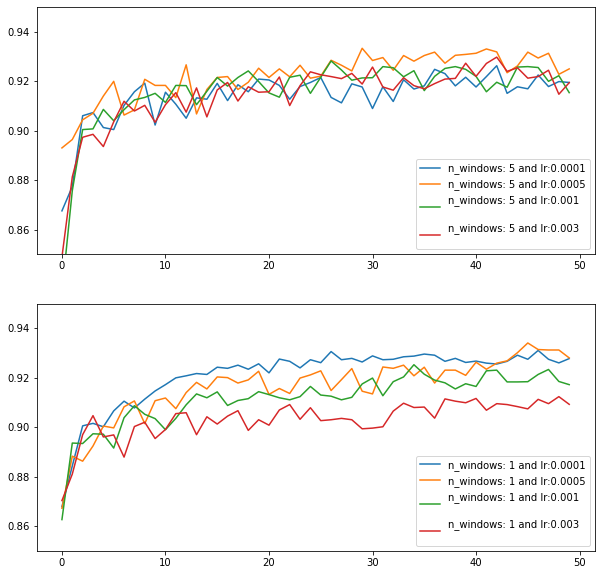

In [37]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
for result in results:
    if result[0]['n_windows'] == 5:
        title = result[2]
        axs[0].plot(result[0]['val_fracs'], label=title[10:36])
    else:
        title = result[2]
        axs[1].plot(result[0]['val_fracs'], label=title[10:36])
axs[1].legend()
axs[0].legend()
axs[1].set_ylim(0.85,0.95)
axs[0].set_ylim(0.85,0.95)